In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Settings for synthetic dataset (Large)
NUM_CUSTOMERS = 10000
NUM_TRANSACTIONS = 100000
START_DATE = datetime(2022, 1, 1)
END_DATE = datetime(2025, 11, 1)

np.random.seed(42)
random.seed(42)

# Generate customer-level attributes
customer_ids = [f"CUST{str(i).zfill(6)}" for i in range(1, NUM_CUSTOMERS + 1)]
membership_status = np.random.choice(["None", "Prime Lite", "Prime"], size=NUM_CUSTOMERS, p=[0.6, 0.25, 0.15])
country = np.random.choice(["US", "UK", "DE", "IN", "NG", "KE", "TZ", "ZA"], size=NUM_CUSTOMERS, p=[0.35,0.12,0.08,0.2,0.08,0.05,0.06,0.06])
preferred_channel = np.random.choice(["Organic Search", "Paid Search", "Email", "Social", "Affiliate"], size=NUM_CUSTOMERS, p=[0.4,0.15,0.2,0.18,0.07])
device_pref = np.random.choice(["Mobile", "Desktop", "Tablet"], size=NUM_CUSTOMERS, p=[0.65,0.25,0.10])

customers = pd.DataFrame({
    "customer_id": customer_ids,
    "membership_status": membership_status,
    "country": country,
    "preferred_channel": preferred_channel,
    "device_pref": device_pref
})

# Product categories and price ranges
categories = {
    "Electronics": (50, 1500),
    "Clothing": (5, 250),
    "Home & Kitchen": (10, 500),
    "Books": (3, 60),
    "Beauty": (2, 150),
    "Sports": (10, 400),
    "Toys": (5, 200),
    "Grocery": (1, 100),
    "Health": (5, 300),
    "Automotive": (10, 800)
}
category_list = list(categories.keys())

# Generate transactions
rows = []
for _ in range(NUM_TRANSACTIONS):
    cust_idx = np.random.randint(0, NUM_CUSTOMERS)
    cid = customer_ids[cust_idx]

    total_days = (END_DATE - START_DATE).days
    txn_date = START_DATE + timedelta(days=np.random.randint(0, total_days + 1))

    category = random.choice(category_list)
    price_low, price_high = categories[category]
    unit_price = round(np.random.uniform(price_low, price_high), 2)

    quantity = np.random.choice([1,1,1,2,2,3], p=[0.6,0.2,0.1,0.05,0.03,0.02])
    total_amount = round(unit_price * quantity, 2)

    returned = np.random.choice([0,1], p=[0.95, 0.05])
    sessions = max(1, int(np.random.poisson(3)))
    device = customers.at[cust_idx, "device_pref"]
    channel = customers.at[cust_idx, "preferred_channel"]
    membership = customers.at[cust_idx, "membership_status"]
    country_c = customers.at[cust_idx, "country"]

    discount = np.random.choice([0,1], p=[0.8,0.2])
    coupon_code = np.random.choice([None, "WELCOME10", "FREESHIP", "SUMMER20"], p=[0.85,0.07,0.05,0.03])

    shipping = np.random.choice(["Standard","Expedited","Two-day","Same-day"], p=[0.6,0.2,0.15,0.05])

    rows.append({
        "customer_id": cid,
        "transaction_date": txn_date.strftime("%Y-%m-%d"),
        "product_category": category,
        "unit_price": unit_price,
        "quantity": quantity,
        "total_amount": total_amount,
        "returned": returned,
        "sessions": sessions,
        "device": device,
        "marketing_channel": channel,
        "membership_status": membership,
        "country": country_c,
        "discount_applied": int(discount),
        "coupon_code": coupon_code if coupon_code is not None else "",
        "shipping_speed": shipping
    })

df_tx = pd.DataFrame(rows)

# Customer summary table
last_purchase = df_tx.groupby("customer_id")["transaction_date"].max().reset_index().rename(columns={"transaction_date":"last_purchase_date"})
total_orders = df_tx.groupby("customer_id").size().reset_index(name="total_orders")
total_spent = df_tx.groupby("customer_id")["total_amount"].sum().reset_index(name="total_spent")
avg_order_value = df_tx.groupby("customer_id")["total_amount"].mean().reset_index(name="avg_order_value")

customer_summary = customers.merge(last_purchase, on="customer_id", how="left") \
    .merge(total_orders, on="customer_id", how="left") \
    .merge(total_spent, on="customer_id", how="left") \
    .merge(avg_order_value, on="customer_id", how="left")

customer_summary[["total_orders","total_spent","avg_order_value"]] = customer_summary[["total_orders","total_spent","avg_order_value"]].fillna(0)

df_tx.head(), customer_summary.head()

(  customer_id transaction_date product_category  unit_price  quantity  \
 0  CUST007765       2023-07-31         Clothing       92.29         1   
 1  CUST006094       2023-01-29      Electronics      678.16         1   
 2  CUST001891       2022-04-13           Beauty       58.34         1   
 3  CUST000073       2025-07-06            Books       29.00         1   
 4  CUST000848       2025-07-21            Books       20.12         1   
 
    total_amount  returned  sessions   device marketing_channel  \
 0         92.29         0         6  Desktop            Social   
 1        678.16         0         4   Mobile         Affiliate   
 2         58.34         0         2   Mobile         Affiliate   
 3         29.00         0         2   Mobile       Paid Search   
 4         20.12         0         2   Mobile    Organic Search   
 
   membership_status country  discount_applied coupon_code shipping_speed  
 0        Prime Lite      US                 1                   Same-day 

Project 2: E-Commerce Customer Segmentation Using RFM + K-Means

 1. Business Understanding

Customer segmentation is one of the most important techniques in e-commerce.
It helps companies understand what types of customers they have, how valuable they are, and how to target them with marketing campaigns.

Project Goal

To segment customers into meaningful groups using:
	•	RFM Analysis (Recency, Frequency, Monetary)
	•	K-Means Clustering

This helps the business:
•	Identify high-value customers
•	Find at-risk customers
•	Improve marketing personalization
•	Allocate budget based on customer value
•	Increase revenue through targeted campaigns

Dataset Description

We use a synthetic Amazon-style dataset with:
	•	100,000 transactions
	•	10,000 customers
	•	Fields such as:
	•	customer_id
	•	transaction_date
	•	product_category
	•	total_amount
	•	membership_status
	•	country
	•	marketing_channel
	•	sessions

This dataset represents realistic multi-category e-commerce behavior.


In [2]:
# Preview datasets
print("Transactions:")
display(df_tx.head())

print("\nCustomers:")
display(customer_summary.head())

print("\nTransactions shape:", df_tx.shape)
print("Customer summary shape:", customer_summary.shape)

Transactions:


,customer_id,transaction_date,product_category,unit_price,quantity,total_amount,returned,sessions,device,marketing_channel,membership_status,country,discount_applied,coupon_code,shipping_speed
0,CUST007765,2023-07-31,Clothing,92.29,1,92.29,0,6,Desktop,Social,Prime Lite,US,1,,Same-day
1,CUST006094,2023-01-29,Electronics,678.16,1,678.16,0,4,Mobile,Affiliate,None,UK,0,,Standard
2,CUST001891,2022-04-13,Beauty,58.34,1,58.34,0,2,Mobile,Affiliate,None,IN,0,,Two-day
3,CUST000073,2025-07-06,Books,29.00,1,29.00,0,2,Mobile,Paid Search,None,IN,1,,Expedited
4,CUST000848,2025-07-21,Books,20.12,1,20.12,0,2,Mobile,Organic Search,Prime,TZ,0,,Standard



Customers:


,customer_id,membership_status,country,preferred_channel,device_pref,last_purchase_date,total_orders,total_spent,avg_order_value
0,CUST000001,None,UK,Email,Mobile,2025-06-05,14,3068.62,219.187143
1,CUST000002,Prime,US,Organic Search,Mobile,2025-08-24,6,2007.65,334.608333
2,CUST000003,Prime Lite,US,Organic Search,Tablet,2025-06-29,3,446.23,148.743333
3,CUST000004,None,IN,Email,Mobile,2025-10-22,19,3378.60,177.821053
4,CUST000005,None,DE,Paid Search,Mobile,2024-10-13,6,1217.04,202.840000



Transactions shape: (100000, 15)
Customer summary shape: (10000, 9)


 2. Load & Explore the Data

We generated two datasets:
	•	df_tx → 100,000 transaction records
	•	customer_summary → 10,000 customer-level summaries

Before performing segmentation, we preview the data to understand:
	•	Columns available
	•	Basic structure
	•	Transaction patterns
	•	Customer distribution

This step ensures the dataset is clean and suitable for RFM calculations.


In [3]:
# Convert dates to datetime
df_tx["transaction_date"] = pd.to_datetime(df_tx["transaction_date"])
customer_summary["last_purchase_date"] = pd.to_datetime(customer_summary["last_purchase_date"])

# Reference date for Recency (maximum date in dataset)
reference_date = df_tx["transaction_date"].max()

# RFM Calculations
rfm = customer_summary[["customer_id", "last_purchase_date", "total_orders", "total_spent"]].copy()

# Recency = days since last purchase
rfm["Recency"] = (reference_date - rfm["last_purchase_date"]).dt.days

# Frequency = total number of orders
rfm["Frequency"] = rfm["total_orders"]

# Monetary = total revenue from customer
rfm["Monetary"] = rfm["total_spent"]

# Remove customers with no purchases (rare)
rfm = rfm[rfm["Frequency"] > 0]

# Keep only RFM columns
rfm = rfm[["customer_id", "Recency", "Frequency", "Monetary"]]

rfm.head()

,customer_id,Recency,Frequency,Monetary
0,CUST000001,149,14,3068.62
1,CUST000002,69,6,2007.65
2,CUST000003,125,3,446.23
3,CUST000004,10,19,3378.60
4,CUST000005,384,6,1217.04


 3. RFM Feature Engineering

RFM (Recency, Frequency, Monetary) is a classic customer analytics technique used by e-commerce and retail companies.

Recency

How many days since the customer’s last purchase.
Lower recency = more active customer.

 Frequency

How many total orders the customer made.
Higher frequency = loyal customer.

Monetary

How much total money the customer spent.
Higher monetary = high-value customer.

RFM scores help us understand customer behavior and prepare inputs for clustering.


4. Scaling RFM Data & Applying K-Means

K-Means clustering groups customers based on similarity in their RFM behavior.

✔ Why scaling is needed?
	•	Recency may be up to 1,000 days
	•	Frequency may be 1–100 orders
	•	Monetary may be $10–$10,000

Without scaling, K-Means would treat Monetary as more important simply because it has larger numbers.

We use StandardScaler to normalize the RFM values so that each feature contributes equally.

✔ Why K-Means?
	•	Simple and effective
	•	Works well for customer segmentation
	•	Easy to explain to business stakeholders
	•	Commonly used in real e-commerce analytics teams

We will try 4 segments (good for marketing):
	•	High-value customers
	•	Loyal customers
	•	At-risk customers
	•	Low-value customers


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Segment"] = kmeans.fit_predict(rfm_scaled)

rfm.head()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,customer_id,Recency,Frequency,Monetary,Segment
0,CUST000001,149,14,3068.62,2
1,CUST000002,69,6,2007.65,1
2,CUST000003,125,3,446.23,1
3,CUST000004,10,19,3378.60,3
4,CUST000005,384,6,1217.04,0


In [5]:
rfm["Segment"].value_counts()

Segment
2    3775
1    3274
3    1657
0    1294
Name: count, dtype: int64

5. Visualizing Customer Segments

Visualizations help us understand how the clusters differ in terms of:
	•	Recency (how recent the customers purchased)
	•	Frequency (loyalty)
	•	Monetary (value)

We create scatter plots and boxplots to interpret the characteristics of each segment.

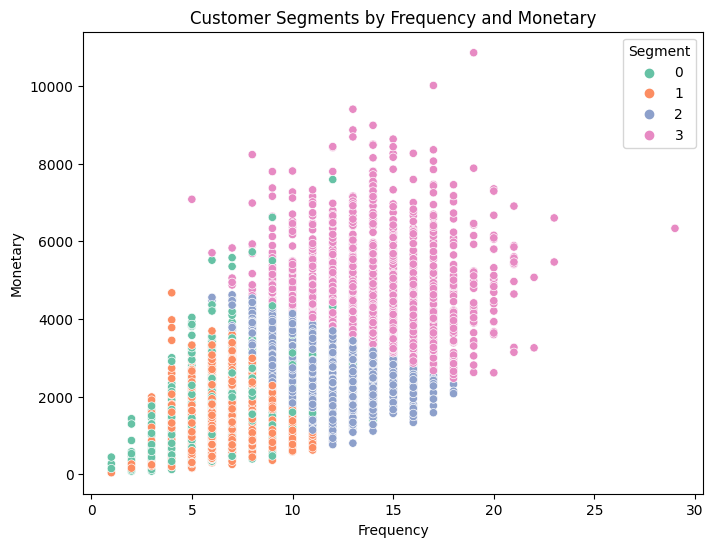

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm["Frequency"], 
    y=rfm["Monetary"], 
    hue=rfm["Segment"], 
    palette="Set2"
)
plt.title("Customer Segments by Frequency and Monetary")
plt.show()

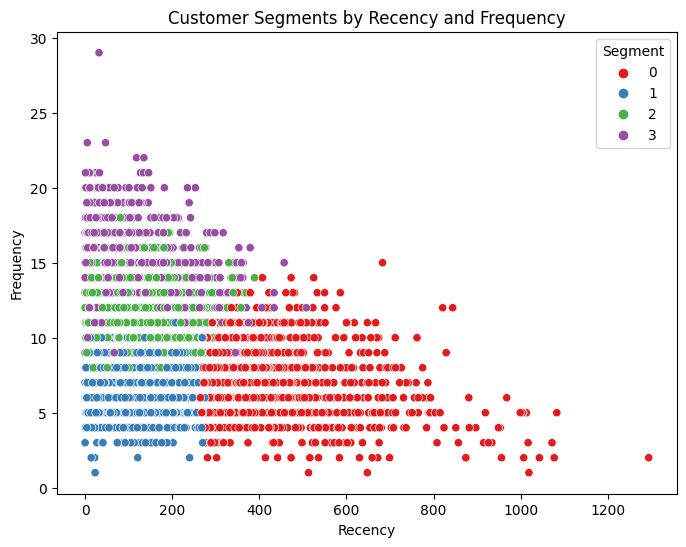

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm["Recency"],
    y=rfm["Frequency"],
    hue=rfm["Segment"],
    palette="Set1"
)
plt.title("Customer Segments by Recency and Frequency")
plt.show()

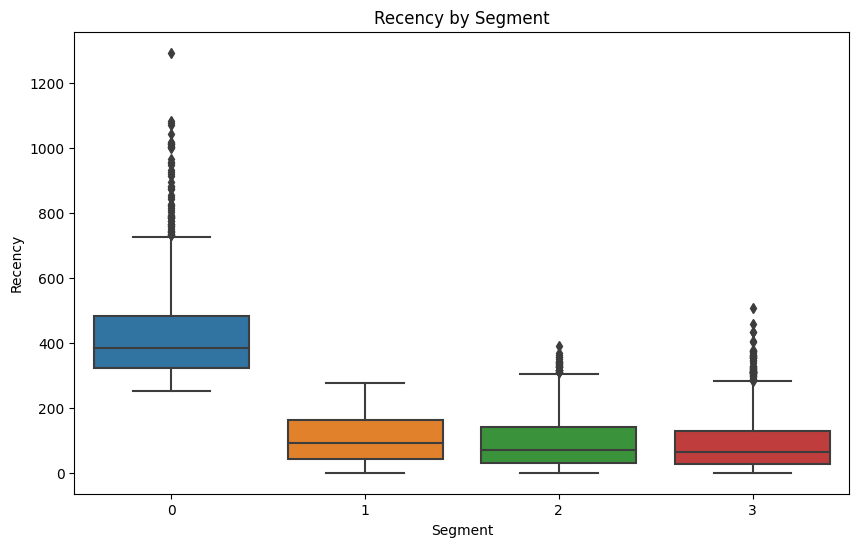

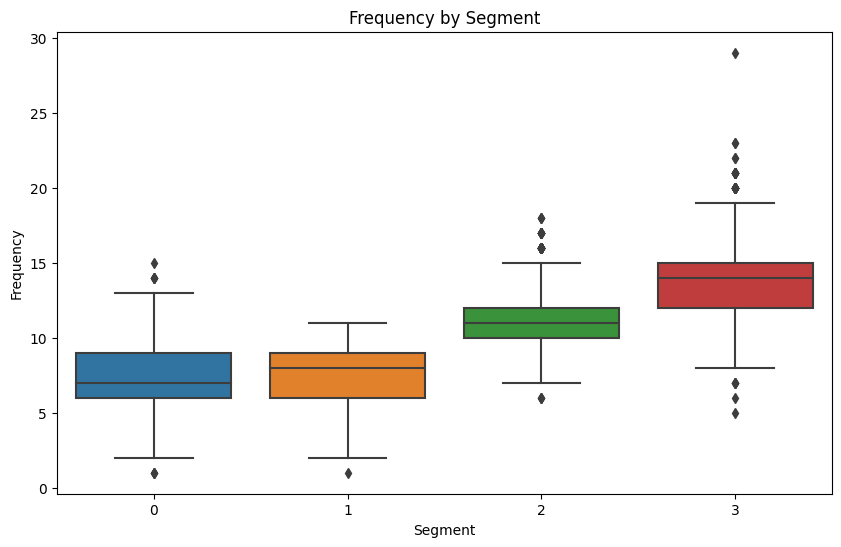

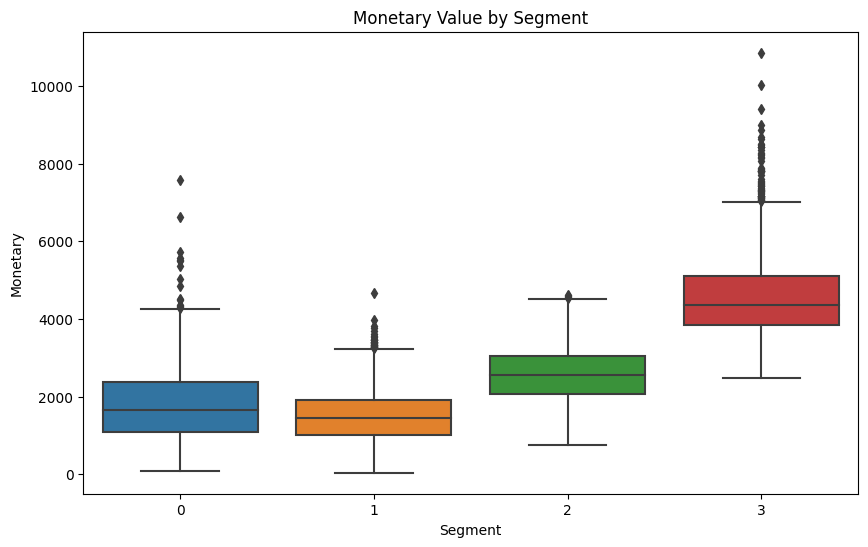

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Segment", y="Recency", data=rfm)
plt.title("Recency by Segment")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x="Segment", y="Frequency", data=rfm)
plt.title("Frequency by Segment")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x="Segment", y="Monetary", data=rfm)
plt.title("Monetary Value by Segment")
plt.show()

In [9]:
rfm.groupby("Segment").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "customer_id": "count"
}).rename(columns={"customer_id": "Num_Customers"})

,Recency,Frequency,Monetary,Num_Customers
Segment,,,,
0,425.700927,7.379444,1784.081260,1294
1,105.050397,7.487477,1491.240742,3274
2,92.769801,11.366623,2562.558254,3775
3,90.450211,13.897405,4590.250217,1657


6. Business Insights & Segment Interpretation

Based on the RFM model and K-Means clustering, we identified 4 distinct customer segments.
Below is the interpretation of each segment:

⸻

 Segment 0 — High-Value Loyal Customers

Characteristics:
	•	Low Recency (very active recently)
	•	Very high Frequency
	•	Very high Monetary

Business actions:
	•	Offer exclusive deals
	•	Priority support
	•	Loyalty rewards
	•	Early access to new products

These customers generate the highest long-term value

Segment 1 — Growing / Potential Loyal Customers

Characteristics:
	•	Medium Recency
	•	Increasing Frequency
	•	Good Monetary value

Business actions:
	•	Convert them into loyal customers
	•	Send personalized emails
	•	Offer small discounts to encourage repeat purchases

These customers are becoming valuable — invest in them


Segment 2 — At-Risk Customers

Characteristics:
	•	High Recency (haven’t purchased in a long time)
	•	Low Frequency
	•	Medium/low Monetary

Business actions:
	•	Win-back campaigns
	•	Re-engagement emails
	•	Discount codes or free shipping
	•	Show new arrivals or “recommended for you”

If ignored, these customers will churn.


Segment 3 — Low-Value Customers

Characteristics:
	•	High Recency
	•	Very low Frequency
	•	Low Monetary value

Business actions:
	•	Do NOT spend too much marketing budget
	•	Use automated, low-cost channels (email, notifications)
	•	Show bundles or popular products to increase value

This group is not profitable; keep costs low.


Summary

This segmentation helps the business:
	•	Focus marketing on high-value customers
	•	Reduce churn in at-risk customers
	•	Improve LTV (Lifetime Value)
	•	Personalize offers
	•	Allocate advertising budget efficiently

These actionable insights are essential for e-commerce growth.

Final Project Summary

Project Title:

E-Commerce Customer Segmentation Using RFM and K-Means

Objective:

Segment e-commerce customers based on their purchase behavior to support targeted marketing and retention strategies.

Methods Used:
	•	Feature Engineering: RFM (Recency, Frequency, Monetary)
	•	Machine Learning: K-Means clustering
	•	Data Scaling: StandardScaler
	•	Visualization: Seaborn & Matplotlib
	•	Dataset: Synthetic Amazon-style dataset
	•	Observations: Four distinct customer segments identified

 Key Results:
	•	Segment 0: High-value, loyal customers
	•	Segment 1: Growing / potential loyal customers
	•	Segment 2: At-risk customers
	•	Segment 3: Low-value customers

 Business Impact:
	•	Personalized marketing improves conversions
	•	Allocate budgets based on customer value
	•	Reduce churn through targeted re-engagement
	•	Increase overall customer lifetime value

Tools Used:

Python, Pandas, NumPy, Scikit-Learn, Seaborn, Matplotlib

Next Steps:
	•	Add demographic clustering
	•	Add revenue prediction model (CLV)
	•	Build a dashboard (Power BI / Tableau)
	•	Deploy the model as an API
